# Depletion
This session is intended to introduce you to the depletion interface/solver contained in OpenMC. In this session, we will model a simple fuel pin in an infinite lattice using the Python API and then build and examine some of the necessary components for performing depletion analysis.

In [1]:
import math
import matplotlib.pyplot as plt
import openmc.deplete

## Build the Geometry

For this demonstration, we will use a simple LWR fuel pin. Note that when running depletion simulations, we need to use the `Model` class:

In [2]:
model = openmc.Model()

# Create materials for fuel, clad, and water
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.4)

clad = openmc.Material(name="clad")
clad.add_element("Zr", 1)
clad.set_density("g/cc", 6)

water = openmc.Material(name="water")
water.add_element("O", 1)
water.add_element("H", 2)
water.set_density("g/cc", 1.0)
water.add_s_alpha_beta("c_H_in_H2O")
model.materials = openmc.Materials([fuel, clad, water])

# Create a fuel pin universe
radii = [0.42, 0.45]
pin_surfaces = [openmc.ZCylinder(r=r) for r in radii]
pin_univ = openmc.model.pin(pin_surfaces, model.materials)

# Put it into a single cell defined as a box with reflective boundary conditions
pitch = 1.24
bound_box = openmc.rectangular_prism(pitch, pitch, boundary_type="reflective")
root_cell = openmc.Cell(fill=pin_univ, region=bound_box)
model.geometry = openmc.Geometry([root_cell])

To ensure our geometry looks right, let's plot it.

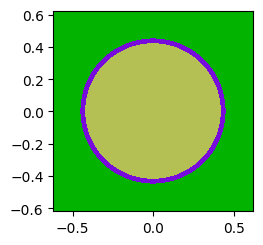

In [3]:
model.geometry.root_universe.plot(width=(1.24, 1.24))

Lastly, we need some basic settings. For the sake of time, a relatively low number of particles will be used.

In [4]:
model.settings = openmc.Settings()
model.settings.particles = 1000
model.settings.inactive = 10
model.settings.batches = 50
model.settings.verbosity = 4

The depletion interface relies on `OpenMC` to perform the transport simulation and obtain reaction rates and other important information. Normally, we would need to export XML files before running OpenMC, but the depletion interface takes care of this for us.

However, we must first add one bit of information: the volume of our fuel. In order to translate the reaction rates obtained by `openmc` to meaningful units for depletion, we have to normalize them to a correct power. This requires us to know, or be able to calculate, how much fuel is in our problem. Correctly setting the volumes is a critical step, and can lead to incorrect answers, as the fuel is over- or under-depleted due to poor normalization.

For our problem, we can assign the "volume" to be the cross-sectional area of our fuel. This is identical to modeling our fuel pin inside a box with height of 1 cm.

In [5]:
fuel.volume = math.pi * radii[0] ** 2

## The `Chain` class

The OpenMC depletion interface can be accessed from the `openmc.deplete` module, and has a variety of classes that will help us. In order to run the depletion calculation we need the following information:

1. Decay modes and half-lives, fission product yields (FPYs), and reaction data
2. Operational power, power density, or source rate (for fixed source calculations)
3. Desired depletion schedule
4. Desired time integration scheme

The additional nuclear data (decay and FPY) are stored in a "depletion chain" XML file that is generated from a combination of the `IncidentNeutron`, `Decay`, and `FissionProductYields` classes we saw yesterday. The `openmc.deplete.Chain` class to aggregate the necessary data. While the `Chain` class has a `from_endf` method that can be used, you may prefer to download pre-generated XML-representations instead at https://openmc.org/depletion-chains/.

For this session, we will be using a much smaller depletion chain that contains very few nuclides that results in shorter simulations.

In [6]:
!cat chain_simple.xml

<?xml version="1.0"?>
<depletion_chain>
  <nuclide name="I135" decay_modes="1" reactions="1" half_life="2.36520E+04">
    <decay type="beta" target="Xe135" branching_ratio="1.0" />
    <reaction type="(n,gamma)" Q="0.0" target="Xe136" /> <!-- Not precisely true, but whatever -->
  </nuclide>
  <nuclide name="Xe135" decay_modes="1" reactions="1" half_life="3.29040E+04">
    <decay type=" beta" target="Cs135" branching_ratio="1.0" />
    <reaction type="(n,gamma)" Q="0.0" target="Xe136" />
  </nuclide>
  <nuclide name="Xe136" decay_modes="0" reactions="0" />
  <nuclide name="Cs135" decay_modes="0" reactions="0" />
  <nuclide name="Gd157" decay_modes="0" reactions="1"  >
    <reaction type="(n,gamma)" Q="0.0" target="Nothing" />
  </nuclide>
  <nuclide name="Gd156" decay_modes="0" reactions="1">
    <reaction type="(n,gamma)" Q="0.0" target="Gd157" />
  </nuclide>
  <nuclide name="U234" decay_modes="0" reactions="1">
    <reaction type="fission" Q="191840000."/>
    <neutron_fission_yield

In [7]:
chain = openmc.deplete.Chain.from_xml("chain_simple.xml")

In [8]:
[nuc.name for nuc in chain.nuclides]

['I135', 'Xe135', 'Xe136', 'Cs135', 'Gd157', 'Gd156', 'U234', 'U235', 'U238']

Generally, we won't need to instantiate the `Chain` class directly since it is handled by other classes under the hood.

## The Depletion `CoupledOperator`

The primary entry point for depletion is the `openmc.deplete.CoupledOperator` class. It relies on the `openmc.deplete.Chain` and helper classes to run `openmc`, retrieve and normalize reaction rates, and other perform other tasks. For a thorough description, please see the full API documentation.

We will create our CoupledOperator using the geometry and settings from above, and our simple chain file. The materials are read in automatically using the `materials.xml` file.

In [9]:
operator = openmc.deplete.CoupledOperator(model, "chain_simple.xml")

Note that instead of explicitly passing the path of the chain file to `CoupledOperator`, it can also be specified through `openmc.config`. We'll use this approach so that we don't need to specify it each time we're creating an operator:

In [10]:
openmc.config['chain_file'] = "chain_simple.xml"

# Now we don't need to pass the chain file anymore
operator = openmc.deplete.CoupledOperator(model)

We will then simulate our fuel pin operating at linear power of 174 W/cm, or 174 W given a unit height for our problem.

In [11]:
power = 174.0

For this problem, we will take depletion step sizes of 30 days, and instruct OpenMC to re-run a transport simulation every 30 days until we have modeled the problem over a six month cycle. The depletion interface expects the time to be given in seconds, so we will have to convert. Note that these values are not cumulative.

In [12]:
time_steps = [30] * 6

And lastly, we will use the basic predictor, or forward Euler, time integration scheme. Other, more advanced methods are provided to the user through `openmc.deplete`

In [13]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')

To perform the simulation, we use the `integrate` method, and let `openmc` take care of the rest.

In [14]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Analyzing Results

The depletion simulation produces a few output files. First, the statepoint files from each individual transport simulation are written to `openmc_simulation_n<N>.h5`, where `<N>` indicates the current depletion step. Any tallies that we defined in `tallies.xml` will be included in these files across our simulations. We have 7 such files, one for each our of 6 depletion steps and the initial state.

In [15]:
!ls *.h5

depletion_results.h5	 openmc_simulation_n3.h5  statepoint.50.h5
openmc_simulation_n0.h5  openmc_simulation_n4.h5  summary.h5
openmc_simulation_n1.h5  openmc_simulation_n5.h5
openmc_simulation_n2.h5  openmc_simulation_n6.h5


The `depletion_results.h5` file contains information that is aggregated over all time steps through depletion. This includes the multiplication factor, as well as concentrations. We can process this file using the `openmc.deplete.Results` object

In [16]:
results = openmc.deplete.Results("depletion_results.h5")
time, k = results.get_keff(time_units='d') # default time is in seconds

k

array([[1.46477526, 0.00392422],
       [1.43890826, 0.00465543],
       [1.43604211, 0.00493173],
       [1.42958815, 0.00429288],
       [1.42754967, 0.00463556],
       [1.42575323, 0.00483288],
       [1.42368305, 0.00459654]])

The first column of `k` is the value of `k-combined` at each point in our simulation, while the second column contains the associated uncertainty. We can plot this using `matplotlib`

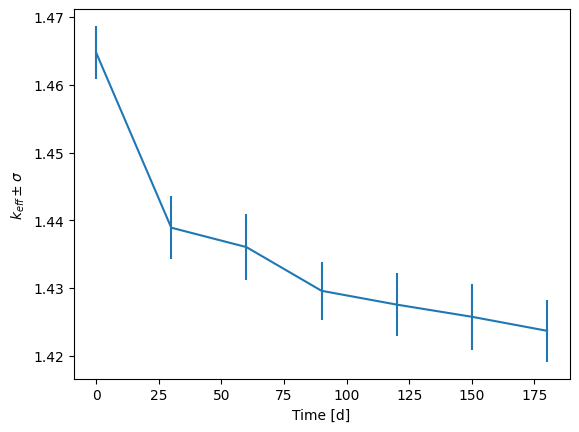

In [17]:
plt.errorbar(time, k[:, 0], yerr=k[:, 1])
plt.xlabel("Time [d]")
plt.ylabel("$k_{eff}\pm \sigma$");

Due to the low number of particles selected, the uncertainty on each value is rather high. However, we can still see the decline over time due to fuel consumption.

We can then examine concentrations of atoms in each of our materials. This requires knowing the material ID, which can be obtained from the `materials.xml` file.

In [18]:
_, u5 = results.get_atoms(fuel, "U235", nuc_units='atom/b-cm')
_, xe135 = results.get_atoms(fuel, "Xe135", nuc_units='atom/b-cm')

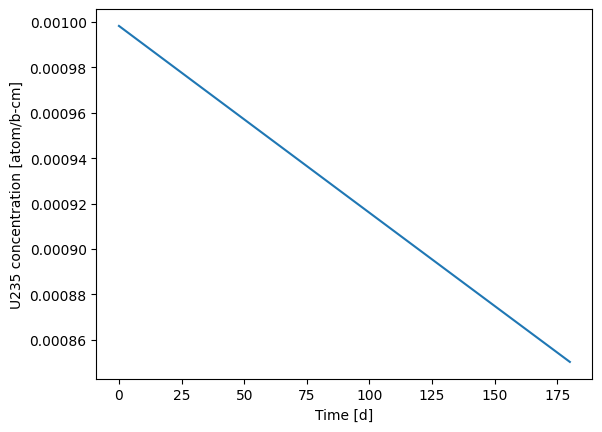

In [19]:
plt.plot(time, u5, label="U235")
plt.xlabel("Time [d]")
plt.ylabel("U235 concentration [atom/b-cm]");

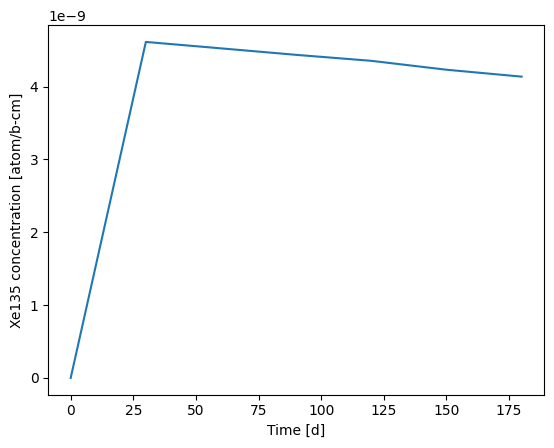

In [20]:
plt.plot(time, xe135, label="Xe135")
plt.xlabel("Time [d]")
plt.ylabel("Xe135 concentration [atom/b-cm]");

We can also examine reaction rates over time using the `Results`

In [21]:
_, u5_fission = results.get_reaction_rate(fuel, "U235", "fission")

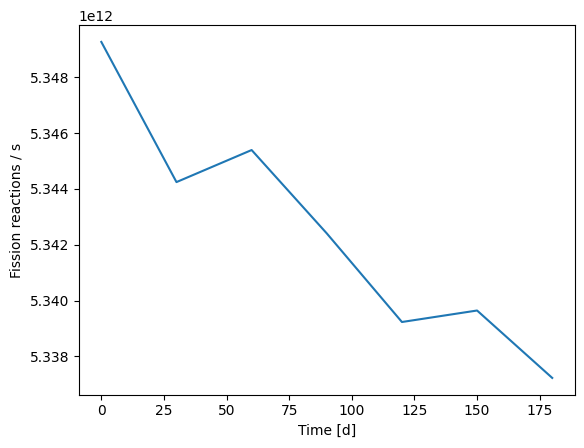

In [22]:
plt.plot(time, u5_fission)
plt.xlabel("Time [d]")
plt.ylabel("Fission reactions / s");

It's also possible to use the `Results` object to create a new set of materials that can be used for a subsequent depletion simulation:

In [23]:
burn_index = results.get_step_where(time=180.)
new_mats = results.export_to_materials(6)
new_mats

[Material
 	ID             =	1
 	Name           =	uo2
 	Temperature    =	None
 	Density        =	10.4 [sum]
 	S(a,b) Tables  
 	Nuclides       
 	O16            =	0.046390654067713206 [ao]
 	O17            =	1.7588724018066154e-05 [ao]
 	U236           =	4.57241954950611e-06 [ao]
 	Cs135          =	1.4500885625296528e-06 [ao]
 	Gd156          =	2.7463447803475693e-08 [ao]
 	Gd157          =	2.641348297770547e-10 [ao]
 	I135           =	9.58189974176822e-09 [ao]
 	U234           =	8.908396934979597e-06 [ao]
 	U235           =	0.0008502750348642368 [ao]
 	U238           =	0.02218494239515605 [ao]
 	Xe135          =	4.1356381244341686e-09 [ao]
 	Xe136          =	6.613999171767768e-06 [ao],
 Material
 	ID             =	2
 	Name           =	clad
 	Temperature    =	None
 	Density        =	6.0 [g/cc]
 	S(a,b) Tables  
 	Nuclides       
 	Zr90           =	0.5145       [ao]
 	Zr91           =	0.1122       [ao]
 	Zr92           =	0.1715       [ao]
 	Zr94           =	0.1738       [ao]
 	Zr96     

## Depletion Integrators

Using higher-order integrators, like the `CECMIntegrator`, `EPCRK4Integrator` with a fourth order Runge-Kutta, or the `LEQIIntegrator`, can improve the accuracy of a simulation, or at least allow you to take longer depletion steps between transport simulations with similar accuracy.

In [24]:
long_steps = [60, 60, 60]

In [25]:
operator = openmc.deplete.CoupledOperator(model)
cecm_int = openmc.deplete.CECMIntegrator(operator, time_steps, power, timestep_units='d')

In [26]:
cecm_int.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

<ErrorbarContainer object of 3 artists>

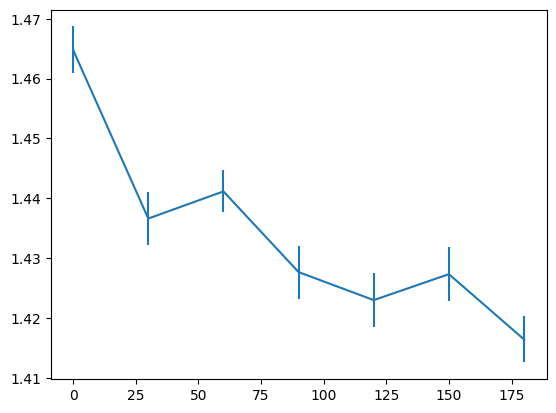

In [27]:
results = openmc.deplete.Results('depletion_results.h5')
time, k = results.get_keff()
time /= (24 * 60 * 60)
plt.errorbar(time, k[:, 0], k[:, 1])

## Integration timestep/power options

In [28]:
# Two 30-day timesteps followed by 10 days of decay
timesteps = [(30, 'd'), (30, 'd'), (6.7, 'h'), (6.7, 'h'), (6.7, 'h')]
power = [174., 174., 0., 0., 0.]
operator = openmc.deplete.CoupledOperator(model)
dep_int = openmc.deplete.CECMIntegrator(operator, timesteps, power, timestep_units='d')
dep_int.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

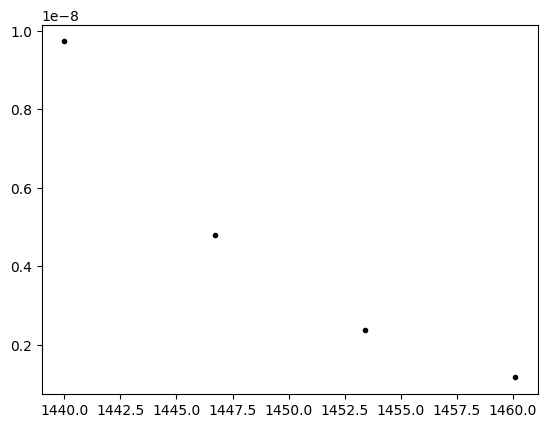

In [29]:
results = openmc.deplete.Results("depletion_results.h5")
time, i135 = results.get_atoms(fuel, "I135", time_units='h', nuc_units='atom/b-cm')
plt.plot(time[-4:], i135[-4:], 'k.')

## Reaction rate / fission product yield modes

By default, OpenMC will determine reaction rates for all transmutation reactions by setting up an tallies for each nuclide/reaction, which can be quite expensive if there are many materials, each with hundreds of nuclides. One alternative is to do a "flux collapse" method, whereby a multigroup flux spectrum is tallied and then *a posteriori* collapsed with the cross sections to determine reaction rates. This is enabled with the `reaction_rate_mode` and `reaction_rate_opts` arguments to `CoupledOperator`.

In [30]:
timesteps = [30] * 6
power = 174.0
operator = openmc.deplete.CoupledOperator(
    model,
    reaction_rate_mode="flux",
    reaction_rate_opts={
        "energies": [0.0, 10.0, 100.3, 20.0e6],
    }
)
dep_int = openmc.deplete.PredictorIntegrator(operator, timesteps, power, timestep_units='d')
dep_int.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

OpenMC also gives a few different ways of specifying what fission product yields to use. By default, it will use thermal FPYs, but this can be changed with the `fission_yield_mode` and `fission_yield_opts` arguments to `CoupledOperator`.

In [31]:
timesteps = [30] * 6
power = 174.0
operator = openmc.deplete.CoupledOperator(model, fission_yield_mode="average")
dep_int = openmc.deplete.PredictorIntegrator(operator, timesteps, power, timestep_units='d')
dep_int.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Normalization (energy) modes

By default, the depletion chain has a set of fixed Q values that are used to estimate energy deposited from fission. However, this doesn't account for energy redistribution/loss from coupled neutron-photon transport or any incident neutron energy-dependent effects. Thus, you should also be aware that OpenMC gives you knobs to turn for how reaction rates are normalized based on observed energy deposition:

```Python
openmc.deplete.CoupledOperator(..., normalization_mode="fission-q")  # fixed Q values for fission
openmc.deplete.CoupledOperator(..., normalization_mode="energy-deposition")  # explicit heating tallies
openmc.deplete.CoupledOperator(..., normalization_mode="source-rate")  # for fixed source (activation) calculations
```

## Reducing a depletion chain

A lot of the computational cost of running depletion has to do with the size and complexity of the depletion chain. OpenMC allows you to "reduce" a depletion chain to a select set of nuclides/pathways which can be very useful if you are only interested in selected nuclides (e.g., activation in a specific material). This is enabled by the `reduce()` method of the `Chain` class. Let's start with a full-blown depletion chain based on ENDF/B-VII.1 and then reduce it to a select set of nuclides for the sake of analyzing activation in nickel.

In [32]:
full_chain = openmc.deplete.Chain.from_xml('chain_endfb71_pwr.xml')
len(full_chain.nuclides)

3819

The `reduce()` method needs a list of initial nuclides, so we'll give the naturally occurring isotopes of Ni.

In [33]:
isotopes = [name for name, abundance in openmc.data.isotopes('Ni')]
isotopes

['Ni58', 'Ni60', 'Ni61', 'Ni62', 'Ni64']

Now we pass this to `reduce()` along with how many "levels" deep we want the depletion chain to be:

In [34]:
new_chain = full_chain.reduce(isotopes, level=1)
new_chain.nuclides

[<Nuclide: H1 (0 modes, 1 reactions)>,
 <Nuclide: He4 (0 modes, 0 reactions)>,
 <Nuclide: Fe55 (1 modes, 0 reactions)>,
 <Nuclide: Fe57 (0 modes, 4 reactions)>,
 <Nuclide: Fe58 (0 modes, 4 reactions)>,
 <Nuclide: Fe59 (1 modes, 0 reactions)>,
 <Nuclide: Fe61 (1 modes, 0 reactions)>,
 <Nuclide: Co58 (1 modes, 4 reactions)>,
 <Nuclide: Co60 (1 modes, 0 reactions)>,
 <Nuclide: Co61 (1 modes, 0 reactions)>,
 <Nuclide: Co62 (1 modes, 0 reactions)>,
 <Nuclide: Co64 (1 modes, 0 reactions)>,
 <Nuclide: Ni57 (1 modes, 0 reactions)>,
 <Nuclide: Ni58 (0 modes, 4 reactions)>,
 <Nuclide: Ni59 (1 modes, 4 reactions)>,
 <Nuclide: Ni60 (0 modes, 4 reactions)>,
 <Nuclide: Ni61 (0 modes, 4 reactions)>,
 <Nuclide: Ni62 (0 modes, 4 reactions)>,
 <Nuclide: Ni63 (1 modes, 0 reactions)>,
 <Nuclide: Ni64 (0 modes, 4 reactions)>,
 <Nuclide: Ni65 (1 modes, 0 reactions)>]

Going 1 level deeper would give us even more nuclides:

In [35]:
new_chain = full_chain.reduce(isotopes, level=2)
new_chain.nuclides

[<Nuclide: H1 (0 modes, 1 reactions)>,
 <Nuclide: H2 (0 modes, 2 reactions)>,
 <Nuclide: He4 (0 modes, 0 reactions)>,
 <Nuclide: Cr54 (0 modes, 4 reactions)>,
 <Nuclide: Cr55 (1 modes, 0 reactions)>,
 <Nuclide: Mn55 (0 modes, 6 reactions)>,
 <Nuclide: Mn57 (1 modes, 0 reactions)>,
 <Nuclide: Mn58 (1 modes, 0 reactions)>,
 <Nuclide: Fe55 (1 modes, 0 reactions)>,
 <Nuclide: Fe56 (0 modes, 4 reactions)>,
 <Nuclide: Fe57 (0 modes, 4 reactions)>,
 <Nuclide: Fe58 (0 modes, 4 reactions)>,
 <Nuclide: Fe59 (1 modes, 0 reactions)>,
 <Nuclide: Fe61 (1 modes, 0 reactions)>,
 <Nuclide: Co57 (1 modes, 0 reactions)>,
 <Nuclide: Co58 (1 modes, 4 reactions)>,
 <Nuclide: Co59 (0 modes, 5 reactions)>,
 <Nuclide: Co60 (1 modes, 0 reactions)>,
 <Nuclide: Co61 (1 modes, 0 reactions)>,
 <Nuclide: Co62 (1 modes, 0 reactions)>,
 <Nuclide: Co64 (1 modes, 0 reactions)>,
 <Nuclide: Ni57 (1 modes, 0 reactions)>,
 <Nuclide: Ni58 (0 modes, 4 reactions)>,
 <Nuclide: Ni59 (1 modes, 4 reactions)>,
 <Nuclide: Ni60 (0 mo

## Matching results with other codes

Getting OpenMC results to match with other codes (e.g., MCNP or Serpent) can be very challenging because of all the inputs that go in to the code. This is especially true for depletion, where we are now concerned not only with getting the transport solution to match but also the depletion integration methods, decay/FPY data, approximations, etc. In order to get a perfect match, you'll need to ensure:

- The model geometry/material definitions are equivalent
- The same neutron cross sections are being used (e.g., ENDF/B-VII.1)
- Same treatment for thermal scattering / probability tables
- Same decay data (depletion chain)
- Same fission product yields (depletion chain)
- Same fission product yield interpolation method (`CoupledOperator(fission_yield_mode=...)`)
- Same fission Q values (`CoupledOperator(fission_q=...)`)
- Same depletion integration method (`PredictorIntegrator`, `CECMIntegrator`, etc.)

Even when all of these are the same, it's still entirely possible to see differences because of other appoximations in the codes that cannot be changed.

## Choice of depletion step size

A general rule of thumb is to use depletion step sizes around 2 MWd/kgHM, where kgHM is really the initial heavy metal mass in kg. If your problem includes integral burnable absorbers, these typically require shorter time steps at or below 1 MWd/kgHM. These are typically valid for the predictor scheme, as the point of recent schemes is to extend this step size. A good convergence study, where the step size is decreased until some convergence metric is satisfied, is a beneficial exercise.

We can use the `CoupledOperator` to determine our maximum step size using this recommendation. The `heavy_metal` attribute returns the mass of initial heavy metal in g, which, using our power, can be used to compute this step size. $$\frac{2\,MWd}{kgHM} = \frac{P\times\Delta}{hm_{op}}$$

In [36]:
operator.heavy_metal

5.080339195584717

In [37]:
max_step = 2 * operator.heavy_metal / power * 1e3

In [38]:
print(f"'Maximum' depletion step: {max_step:5.3} [d]")

'Maximum' depletion step:  58.4 [d]


Alternatively, if we were provided the power density of our problem, we can provide this directly with `openmc.deplete.PredictorIntegrator(operator, time_steps, power_density=pdens)`. The values of `power` and `power_density` do not have to be scalars. For problems with variable power, we can provide an iterable with the same number of elements as `time_steps`.

## Differentiating burnable materials

OpenMC allows you to differentiate materials that reappear in multiple places. If we had built an entire core with the single `fuel` material, every pin would be depleted using the same averaged spectrum and reaction rates, which is physically incorrect. The `CoupledOperator` can differentiate these materials using the `diff_burnable_mats` argument. In the case, the volume assigned to the original material will be divided over each new instance of the material.

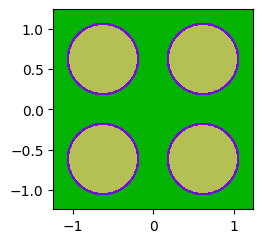

In [39]:
new_model = openmc.Model()
new_model.settings = model.settings

# Create materials for fuel, clad, and water
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.4)
fuel.volume = 4 * math.pi * radii[0] ** 2

clad = openmc.Material(name="clad")
clad.add_element("Zr", 1)
clad.set_density("g/cc", 6)

water = openmc.Material(name="water")
water.add_element("O", 1)
water.add_element("H", 2)
water.set_density("g/cc", 1.0)
water.add_s_alpha_beta("c_H_in_H2O")
model.materials = openmc.Materials([fuel, clad, water])

# Create a fuel pin universe
radii = [0.42, 0.45]
pin_surfaces = [openmc.ZCylinder(r=r) for r in radii]
materials = [fuel, clad, water]
pin_univ = openmc.model.pin(pin_surfaces, model.materials)

lattice = openmc.RectLattice()
lattice.lower_left = (-pitch, -pitch)
lattice.pitch = (pitch, pitch)
lattice.universes = [
    [pin_univ, pin_univ],
    [pin_univ, pin_univ]
]
lattice.outer = pin_univ

# Put it into a single cell defined as a box with reflective boundary conditions
bound_box = openmc.rectangular_prism(2*pitch, 2*pitch, boundary_type="reflective")
root_cell = openmc.Cell(fill=lattice, region=bound_box)
new_model.geometry = openmc.Geometry([root_cell])

new_model.geometry.root_universe.plot(width=(2*pitch, 2*pitch))

In [40]:
new_op = openmc.deplete.CoupledOperator(new_model, diff_burnable_mats=True)
integrator = openmc.deplete.PredictorIntegrator(new_op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/romano/openmc/openmc/deplete/coupled_operator.py:541: FutureWarning: The Operator(...) class has been renamed and will be removed in a future version of OpenMC. Use CoupledOperator(...) instead.
  warn(


 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
[openmc.deplete] t=0.0 s, dt=2592000 s, source=174.0

 ====================>     K EIGENVALUE SIMULATION     <====================


 ============================>     RESULTS     <============================

 k-effective (Collision)     = 1.46683 +/- 0.00821
 k-effective (Track-length)  = 1.47673 +/- 0.01030
 k-effective (Absorption)    = 1.46726 +/- 0.00462
 Combined k-effective        = 1.46844 +/- 0.00484
 Leakage Fraction            = 0.00000 +/- 0.00000

[openmc.deplete] t=2592000.0 s, dt=2592000 s, source=174.0

 ====================>     K EIGENVALUE SIMULATION     <====================


 ============================>     RESULTS     <============================

 k-effective (Collision)     = 1.45019 +/- 0.00592
 k-effective (Track-length)  = 1.44838 +/- 0.00783
 k-effective (Absorption)    = 1.44927 +/- 0.00422
 Combined k-effective        = 1.44892 +/- 0.00398
 Leakage Fra

## Independent depletion operator

The `CoupledOperator` class, in conjunction with the integrator classes, will execute a transport solve one or more times for each depletion step. However, in some cases you may wish to just collapse reaction rates at each step based on a known neutron flux. This can be done in OpenMC using the `openmc.deplete.IndependentOperator` class. This class takes a `Materials` object as well as a set of microscopic cross sections, represented using the `openmc.deplete.MicroXS` class. The `MicroXS` class, in turn, can be created based on an existing `Model` as

In [41]:
micro_xs = openmc.deplete.MicroXS.from_model(model, fuel)
micro_xs

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/romano/openmc/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/home/romano/openmc/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)


 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K

 ====================>     K EIGENVALUE SIMULATION     <====================


 ============================>     RESULTS     <============================

 k-effective (Collision)     = 1.45694 +/- 0.00735
 k-effective (Track-length)  = 1.46041 +/- 0.01026
 k-effective (Absorption)    = 1.46083 +/- 0.00498
 Combined k-effective        = 1.45985 +/- 0.00487
 Leakage Fraction            = 0.00000 +/- 0.00000



,"(n,gamma)",fission
nuclide,,
U234,22.955001,0.497299
U235,10.481497,48.554324
U238,0.856027,0.106600
U236,9.220687,0.328571
O16,0.000075,0.000000
O17,0.000408,0.000000
I135,6.847451,0.000000
Xe135,228106.427081,0.000000
Xe136,0.023142,0.000000


Now that we have a set of microscopic cross sections, we can create the independent operator and run a depletion simulation (with no transport solves!).

In [42]:
# Create independent operator
independent_op = openmc.deplete.IndependentOperator(model.materials, micro_xs)

# Run depletion
integrator = openmc.deplete.PredictorIntegrator(independent_op, time_steps, power, timestep_units='d')
integrator.integrate()

[openmc.deplete] t=0.0 s, dt=2592000 s, source=174.0
[openmc.deplete] t=2592000.0 s, dt=2592000 s, source=174.0
[openmc.deplete] t=5184000.0 s, dt=2592000 s, source=174.0
[openmc.deplete] t=7776000.0 s, dt=2592000 s, source=174.0
[openmc.deplete] t=10368000.0 s, dt=2592000 s, source=174.0
[openmc.deplete] t=12960000.0 s, dt=2592000 s, source=174.0
[openmc.deplete] t=15552000.0 (final operator evaluation)
